# Looking at EEG power spectra

Here we examine a number of ways in which the frequency content of EEG data can be assessed.

We use the N170 dataset as an example, but the following can be used with minimal adjustments with any eeg or time series data.

## Setup

In [155]:
# Generic imports
import os,sys,glob,numpy as np, pandas as pd

# eeg-notebooks utils
from utils import utils

# mne functions
from mne import Epochs, find_events
from mne.time_frequency import psd_welch

# visualization stuff
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# others
from scipy.signal import welch

## Load the data

We will use session 1, subject 1 from the eeg notebooks example N170 dataset

In [100]:
subject = 1
session = 1
raw = utils.load_data('visual/N170', sfreq=256., 
                      subject_nb=subject, session_nb=session)

Creating RawArray with float64 data, n_channels=5, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.


In [101]:
#raw.filter(1,50)

## Calculate PSD for a raw (non-epoched) recording

This is the simplest option.

In [102]:
# compute the poweer spectral density (PSD) using 
# the MNE psd_welch function
# (this is simply a wrapper on scipy.signal.welch
#  that adds compatbility for MNE data types)

psd,freqs = psd_welch(raw)

# Place in a pandas dataframe for convenience

df_psd = pd.DataFrame(psd, columns=freqs).T
df_psd.columns = raw.ch_names[:4]
df_psd.index.names = ['freq']
df_psd.columns.names = ['chan']

Effective window size : 1.000 (s)


In [105]:
# (reminder: pandas dataframes are like a bit like excel spreadsheets. 
#  You can view their contents within notebooks with commands like the following: 

df_psd.iloc[:10,:]

chan,TP9,AF7,AF8,TP10
freq,,,,
0.0,6.452557e-12,8.864775e-13,9.323995e-13,1.010397e-11
1.0,4.918377e-11,6.973704e-12,5.596043e-12,7.221282e-11
2.0,7.759577e-11,4.977196e-12,2.742295e-12,8.247680e-11
3.0,7.283876e-11,3.605525e-12,1.478476e-12,7.560045e-11
4.0,5.408951e-11,2.582165e-12,1.044598e-12,5.656305e-11
5.0,2.842555e-11,1.509509e-12,8.726531e-13,3.005558e-11
6.0,1.218337e-11,8.599208e-13,7.280237e-13,1.305531e-11
7.0,5.943665e-12,6.510389e-13,5.716192e-13,6.500837e-12
8.0,3.861607e-12,4.741375e-13,4.438558e-13,3.978852e-12


Plot the full power spectrum

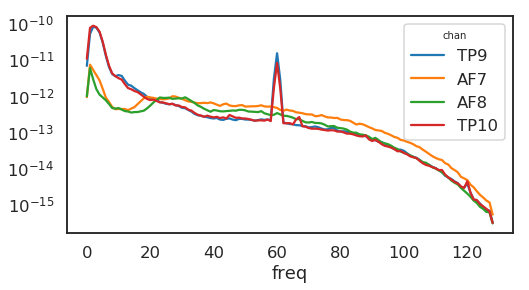

In [111]:
fig, ax = plt.subplots(figsize=(8,4))
df_psd.plot(logy=True,ax=ax)

Double checking this agains the MNE `plot_psd` function, which should compute and plot the same numbers (with a few small differences in scaling and visualization):

Effective window size : 8.000 (s)


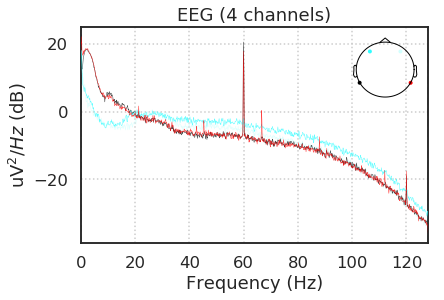

In [157]:
raw.plot_psd();

Remember, the 60Hz spike in the power spectrum is an artifact due to the pervasive mains electricity background noise. 

Now, calculate the average power within a set of pre-defined canonical frequency bands

In [187]:
# These are the conventional EEG frequency band names and ranges

freqs = ['delta', 'theta', 'alpha', 'beta', 'lowgamma', 'midgamma']

freq_bands = dict(delta = [0.5,2],
                  theta = [4,8], 
                  alpha = [8,12], 
                  beta = [12,20],
                  lowgamma=[20,30],
                  midgamma=[30,50])

# Average the power within each of these bands

psd_fb = {}
for band_name, (rlow,rhigh) in freq_bands.items():
    psd_fb[band_name] = df_psd.loc[rlow:rhigh].mean(axis=0)

    
# Put in a pandas dataframe

df_psd_fb = pd.DataFrame(psd_fb).T.loc[freqs]
df_psd_fb.index.names = ['freq band']

Now plot the power in each frequency band for the four sensors:

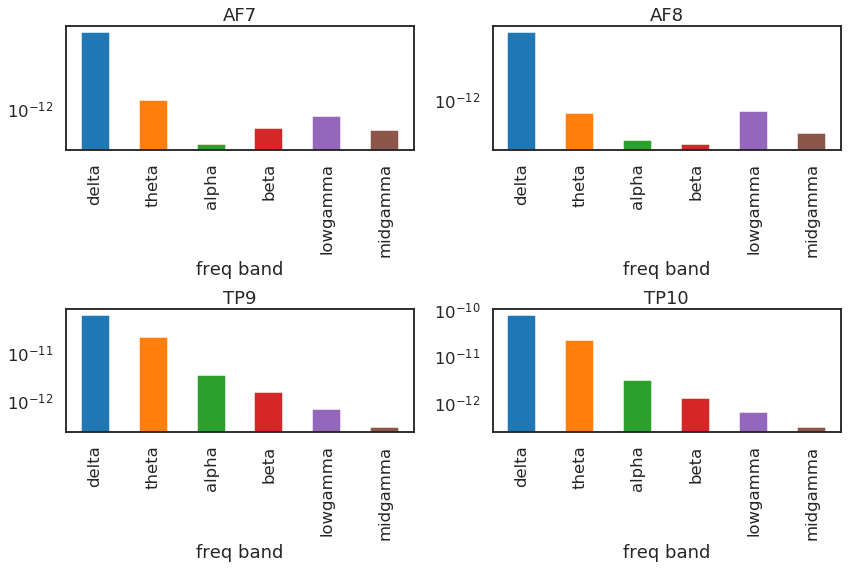

In [188]:
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(12,8))

sens,thisax = 'AF7', ax[0][0]
df_psd_fb[sens].plot(kind='bar', ax=thisax,logy=True)
thisax.set_title(sens)

sens,thisax = 'AF8', ax[0][1]
df_psd_fb[sens].plot(kind='bar', ax=thisax,logy=True)
thisax.set_title(sens)

sens,thisax = 'TP9', ax[1][0]
df_psd_fb[sens].plot(kind='bar', ax=thisax,logy=True)
thisax.set_title(sens)

sens,thisax = 'TP10', ax[1][1]
df_psd_fb[sens].plot(kind='bar', ax=thisax,logy=True)
thisax.set_title(sens)


plt.tight_layout()

Complementary plot: power for each frequency band as a function of sensor:

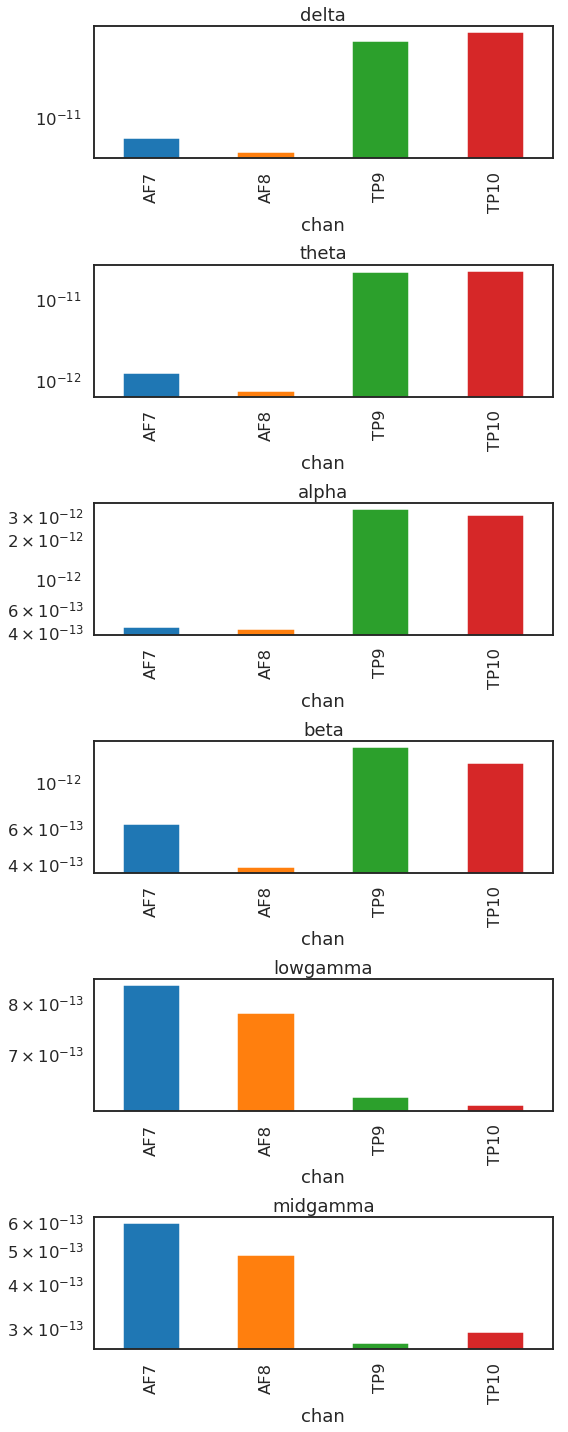

In [190]:
fig, ax = plt.subplots(nrows=6, figsize=(8,20))


chans = ['AF7', 'AF8', 'TP9', 'TP10']

thisfreq,thisax = 'delta', ax[0]
df_psd_fb[chans].loc[thisfreq].plot(kind='bar',ax=thisax,logy=True)
thisax.set_title(thisfreq);

thisfreq,thisax = 'theta', ax[1]
df_psd_fb[chans].loc[thisfreq].plot(kind='bar',ax=thisax,logy=True)
thisax.set_title(thisfreq);

thisfreq,thisax = 'alpha', ax[2]
df_psd_fb[chans].loc[thisfreq].plot(kind='bar',ax=thisax,logy=True)
thisax.set_title(thisfreq);

thisfreq,thisax = 'beta', ax[3]
df_psd_fb[chans].loc[thisfreq].plot(kind='bar',ax=thisax,logy=True)
thisax.set_title(thisfreq);

thisfreq,thisax = 'lowgamma', ax[4]
df_psd_fb[chans].loc[thisfreq].plot(kind='bar',ax=thisax,logy=True)
thisax.set_title(thisfreq);

thisfreq,thisax = 'midgamma', ax[5]
df_psd_fb[chans].loc[thisfreq].plot(kind='bar',ax=thisax,logy=True)
thisax.set_title(thisfreq);


plt.tight_layout()